In [1]:
projectdir = "C:/Users/ArmanAngaji/OneDrive - Universität zu Köln/Dokumente/Uni-Köln/Masterarbeit/Workspace/Julia_Master/MasterProject_Julia/"
cd(projectdir)
using Pkg; Pkg.activate(pwd())

using DataFrames, StatsBase, Plots, Statistics, LaTeXStrings, LsqFit, CSV, Pipe, ProgressMeter, StatsPlots, BSON
using Distributions, NLsolve, Roots
pyplot()

try
    Turnover
catch e
    include(projectdir*"Turnover/src/Turnover.jl")
    include(projectdir*"Turnover/src/test.jl")
    using .Turnover
end
try
    SeqDataFormatting
catch e
    include("experimental_data/SeqDataFormatting.jl")
    import .SeqDataFormatting
end

import TumorGrowth
include("distribution_functions.jl")
plot(size=(1,1))

  Activating environment at `C:\Users\ArmanAngaji\OneDrive - Universität zu Köln\Dokumente\Uni-Köln\Masterarbeit\Workspace\Julia_Master\MasterProject_Julia\Project.toml`

Test Summary:             | Pass  Total
Applying turnover methods

 |    7      7


# Data
> Load data and set turnover settings

In [52]:
sampleinfo = TumorGrowth.data_import("experimental_data/wes_sampleinfo.csv", delim=",")
normal = "N1"
tumorsamples = sampleinfo.samplename
samples = [tumorsamples..., normal]

mutations_string = (DataFrame ∘ CSV.File)("experimental_data/MichelProcessed/Ling2015_jointcall_pwrecovered.csv")

seqdata = SeqDataFormatting.string_to_seqresult(mutations_string, samples);

wes = SeqDataFormatting.seqdata_to_tumor(seqdata, sampleinfo; normal = "N1", 
    maxReadsNormal = 0, 
    minReads = 5,
    minTotCoverage = 150,
    cnaAgreement = 0,
    allow_xy = true,
    cutoff_hi = 0.5,
    cutoff_low = 1/40,
    )
wes.frequencies = copy(wes.ccf);
vcat(wes.mutations...) |> unique |> length

249

In [59]:
turnover_params = ( Nthresh_orph = 40, Nthresh_estr = 40, )

tumor = deepcopy(wes)
SeqDataFormatting.subsample!(tumor; nmuts = 50)
for s in eachrow(tumor)
    mask = s.frequencies .> 1/2
    s.mutations = s.mutations[mask]
    s.frequencies = s.frequencies[mask]
end

freqs = SeqDataFormatting.mfreqs(tumor) |> df -> Dict(df.mutation .=> df.frequency)
;

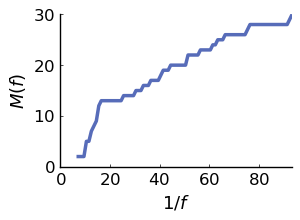

In [60]:
p = plot(size=(300,220), legend=:none, grid=false,
    ytickfontsize=12, margin=2Plots.mm, tickfontsize=12, labelfontsize=13)

res = 1/100
M!(p, filter( f-> 1 > f > res, collect(values(freqs))), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    lw=2.5, xlim=(0, :auto), ylim=(0,:auto), color=cgrad(:blues)[0.5])
# savefig("experimental_data\\LingProcessed\\plots\\Ling_wes_sfs.pdf")

# single call

In [55]:
orphaned_tumor = DataFrame( mutations = unique( 
        filter.(m-> freqs[m] > 1/turnover_params[:Nthresh_orph], tumor.mutations) 
        ) )

# get d
W_l = orphaned_red_treeless(orphaned_tumor) |> 
    df -> sum( df.isorphaned ) / sum( df.isgreen )

d_solve = fzero(x -> min(1., Turnover.W_orphaned( x; N= turnover_params[:Nthresh_orph] * (1-x))) - W_l, 0.01, 0.99) 

0.09240738373776959

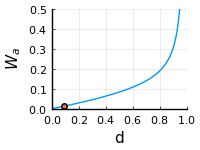

In [56]:
plot(0:0.01:1., x -> Turnover.W_orphaned( x; N= turnover_params[:Nthresh_orph]*(1-x) ),
    xlim=(0,1), ylim=(0,0.5), size=(200,150), lab=:none)
scatter!([d_solve], [W_l], lab=:none, xlab=:d, ylab=L"W_a")

In [57]:
estranged_tumor = DataFrame(mutations = 
    filter( muts -> all(  freqs[m] > 1/turnover_params[:Nthresh_estr] for m in muts), tumor.mutations) )

# get mu
W_c = estranged_treeless(estranged_tumor) |> 
        df -> sum( df.isestranged ) / sum( df.isgreen )

mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu, 
            T=log(turnover_params[:Nthresh_estr] * (1-d_solve)) / (1-d_solve)))- W_c, 0.01, 0.99)

0.99

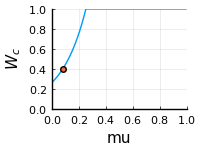

In [29]:
plot(0:0.001:1., mu -> min(1., W_estranged(d_solve; b=1., μ=mu, T=log(turnover_params[:Nthresh_estr]*(1-d_solve))/(1-d_solve))),
    xlim=(0,1), ylim=(0,1.0), size=(200,150), lab=:none)
scatter!([mu_solve], [W_c], lab=:none, xlab=:mu, ylab=L"W_c")

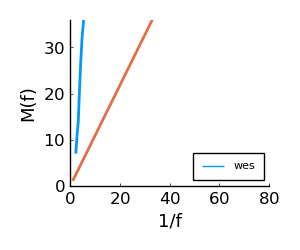

In [58]:
wes_freqs = SeqDataFormatting.mfreqs(wes).frequency

p = plot(layout=(1,1), size=(300,250), grid=false, xlab=L"1/f", ylab=L"M(f)", xlim=(0, :auto),
    labelfontsize=13, tickfontsize=12, margin=5Plots.mm, legend=:bottomright)
M!(p[1], wes_freqs, nbins=50, lab="wes", lw=2., ylim=(0,36))
plot!(p[1], 1:80, x-> x*mu_solve/(1-d_solve), lw=2., lab="")

# sampling

0.7940798394372962


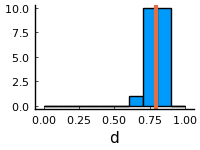

In [11]:
ds = map( 20:1:40) do M

    orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/M, tumor.mutations) ) )
    
    # get d
    W_l = orphaned_red_treeless(orphaned_tumor) |> 
        df -> sum( df.isorphaned ) / sum( df.isgreen )
    d_solve = try
        fzero(x -> min(1., Turnover.W_orphaned( x; N= M * (1-x) )) - W_l, 0.01, 0.99)
    catch e
        e isa ArgumentError && 1.
    end
end
println(median(ds))
histogram(ds, bins=0.:0.1:1., size=(200,150), lab="")
vline!([median(ds)], lab="", lw=3., grid=false, xlab=:d)

0.7482915548905031


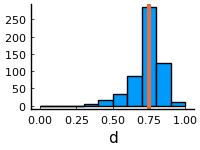

In [12]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/turnover_params[:Nthresh_orph], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)
        
        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x; N= turnover_params[:Nthresh_orph] * (1-x))) - W_l, 0.01, 0.99)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
println(median(vcat(ds...)))
histogram(vcat(ds...), bins=0.:0.1:1., size=(200,150), lab="")
vline!([median(vcat(ds...))], lab="", lw=3., grid=false, xlab=:d)

In [13]:
d_solve=0.75

0.75

In [14]:
estranged_tumor = DataFrame(mutations = filter( muts -> all(  freqs[m] > 1/turnover_params[:Nthresh_estr] for m in muts), tumor.mutations) )

# get mu
W_c = estranged_treeless(estranged_tumor) |> 
        df -> sum( df.isestranged ) / sum( df.isgreen )

mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu,
            T=log(turnover_params[:Nthresh_estr] * (1-d_solve) )/(1-d_solve)))- W_c, 0.01, 0.99)

0.07928885578527746

mean fit : 0.07916210519873246
averaged fits : 0.07535693959579605 ± 0.0029522494368844246


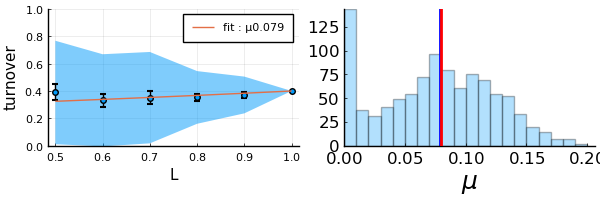

In [15]:
let d = d_solve
    Ls = 0.5:0.1:1.
    reps = 50
    estranged_tumors = map( Ls ) do L
        [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
    end

    estranged_turnover = map(estranged_tumors) do set
            filter!(!isnan, map(set) do tumor
                res = estranged_treeless(tumor)
                sum( res.isestranged ) / sum( res.isgreen )
                end ) 
        end

    Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])
    
    global Nthresh
    function model(Ls, p)
        local mu = p[1]
        (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
        map( Ls ) do L
            min(1., W_estranged(d; b=1., μ=mu*L, T=log(turnover_params[:Nthresh_estr] * (1-d))/(1-d)))
        end
    end
    fit = curve_fit(model, Ls, mean.(t), [(1-d)/2])
    mu_fit = fit.param[1]

    p1 = scatter( Ls, mean.(t), ribbon=std.(t), yerror = std.(t)./sqrt.(length.(t)), lab="", xlab=:L, ylab=:turnover, legend=:topright, ylim=(0,1))
    plot!(Ls, model(Ls, fit.param), lab="fit : μ$(round(mu_fit,digits=3))" )

    tvecs = [ rand.(t) for _=1:1000 ]
    fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
    mu_fits = getindex.(getfield.(fits, :param),1)
    p2 = histogram( mu_fits, lab="", alpha=0.3, xlim=(0,:auto), nbins=30, size=(400,250), ylim=(0,:auto))
    vline!([mu_fit], lab="", lw=2., c=:blue, tickfontsize=12, labelfontsize=18, xlab=L"\mu", grid=false )
    vline!([mu_solve], lab="", lw=2., c=:red)

    println("mean fit : ", mu_fit)
    println("averaged fits : ", mean(mu_fits), " ± ", 1.96*std(mu_fits)/sqrt(length(mu_fits)))
    plot(p1,p2, size=(600,200))

#     savefig("Turnover/turnover_plots/experimental_data/sanger_wesfreqs_mu.pdf")
end

In [50]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/turnover_params[:Nthresh_orph], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x; N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.01, 0.99)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
ds = vcat(ds...)
d_solve = median(ds)

estranged_tumor = DataFrame(mutations = 
    filter( muts -> all(  freqs[m] > 1/turnover_params[:Nthresh_estr] for m in muts), tumor.mutations) )
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen ) #|> mes2theory_estranged

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu,
# T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu,
            T=log(turnover_params[:Nthresh_estr] * (1-d_solve) )/(1-d_solve)))- W_c, 0.01, 0.99)

Ls = 0.4:0.1:1.
reps = 50
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, set .|> estranged_treeless .|> df -> sum( df.isestranged ) / sum( df.isgreen ))
    end

Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1., μ=mu*L, T=log(turnover_params[:Nthresh_estr] * (1-d_solve))/(1-d_solve)))
    end
end
# fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve)/2])
fitres = curve_fit(model, vcat( [ fill(Ls[i], length(t_)) for (i,t_) in enumerate(t)]... ), 
    vcat(t...), [(1-d_solve)/2])
mu_fit = fitres.param[1]

tvecs = [ rand.(t) for _=1:1000 ]
fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
mu_fits = getindex.(getfield.(fits, :param),1)


p = plot(layout=(1,1), size=(300,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

plot!(p[1], legend=:none, xlim=(0.2,2.8), xtickfontsize=18, ylim=(0,1), xticks=([1,2],[L"d",L"\mu"]))#, xaxis=:off)
hline!(p[1], [1], c=:black, lw=1.5)
vline!(p[1], [2.8], c=:black, lw=1.5)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [d_solve], c=:blue, lw=2., style=:dash)
println(d_solve)

violin!(p[1], [2], mu_fits, c=:red, fillalpha=0.5)
scatter!(p[1], [2], mu_fits, c=:red, alpha=0.5)
hline!(p[1], [median(mu_fits)], c=:red, lw=2., style=:dash)
println(median(mu_fits))
# hline!(p[1], [mu_solve], c=:orange, lw=2., style=:dash)

# res = 1/400
# plot!(p[2], tickfontsize=12, labelfontsize=13)
# M!(p[2], filter( f-> 1 > f > res, collect(values(freqs))), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
#     lw=2., xlim=(0, :auto), ylim=(0,40))
# plot!(p[2], 1:80, x-> x*median(mu_fits)/(1-d_solve), lw=2., lab="")

0.7482915548905031
0.08125790704616287


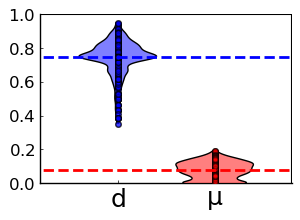

In [51]:
p

In [53]:
# savefig("Turnover\\turnover_LingLichee_inference.pdf")

0.5313483952898252
0.293017690522415


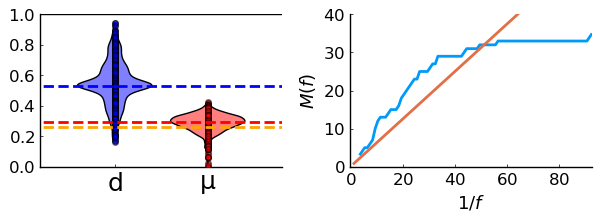

In [176]:
ds = map( 0.5:0.1:1. ) do L
    map( 1:100 ) do _
        orphaned_tumor = DataFrame( mutations = unique( filter.(m-> freqs[m] > 1/turnover_params[:Nthresh_orph], tumor.mutations) ) )
        orphaned_tumor = TumorGrowth.reduced_μ(orphaned_tumor, L)

        # get d
        W_l = orphaned_red_treeless(orphaned_tumor) |> 
            df -> sum( df.isorphaned ) / sum( df.isgreen )

        d_solve = try
            fzero(x -> min(1., Turnover.W_orphaned( x; N= turnover_params[:Nthresh_orph]*(1-x))) - W_l, 0.01, 0.99)
        catch e
            e isa ArgumentError && NaN
        end
    end
end
filter!.(!isnan, ds)
ds = vcat(ds...)
d_solve = median(ds)

estranged_tumor = DataFrame(mutations = 
    filter( muts -> all(  freqs[m] > 1/turnover_params[:Nthresh_estr] for m in muts), tumor.mutations) )
# get mu
W_c = estranged_treeless(estranged_tumor) |> df -> sum( df.isestranged ) / sum( df.isgreen ) #|> mes2theory_estranged

# mu_solve, n = bisection(mu -> min(1., W_estranged(d_solve; b=1, μ=mu,
# T=log(turnover_params[:Nthresh_estr])/(1-d_solve)))- W_c, [0.01,0.99], 100)
mu_solve = fzero(mu -> min(1., W_estranged(d_solve; b=1., μ=mu,
            T=log(turnover_params[:Nthresh_estr] * (1-d_solve) )/(1-d_solve)))- W_c, 0.01, 0.99)

Ls = 0.4:0.1:1.
reps = 50
estranged_tumors = map( Ls ) do L
    [TumorGrowth.reduced_μ(estranged_tumor, L) for _=1:reps]
end

estranged_turnover = map(estranged_tumors) do set
        filter!(!isnan, set .|> estranged_treeless .|> df -> sum( df.isestranged ) / sum( df.isgreen ))
    end

Ls, t = .!isempty.(estranged_turnover) |> mask -> (Ls[mask], estranged_turnover[mask])

function model(Ls, p)
    local mu = p[1]
    (mu<=0. || mu>=1.) && return fill(Inf, length(Ls))
    map( Ls ) do L
        min(1., W_estranged(d_solve; b=1., μ=mu*L, T=log(turnover_params[:Nthresh_estr] * (1-d_solve))/(1-d_solve)))
    end
end
# fitres = curve_fit(model, Ls, mean.(t), [(1-d_solve)/2])
fitres = curve_fit(model, vcat( [ fill(Ls[i], length(t_)) for (i,t_) in enumerate(t)]... ), 
    vcat(t...), [(1-d_solve)/2])
mu_fit = fitres.param[1]

tvecs = [ rand.(t) for _=1:1000 ]
fits = map( tp-> curve_fit(model, Ls, tp, [(1-d_solve)/2]), tvecs)
mu_fits = getindex.(getfield.(fits, :param),1)


p = plot(layout=(1,2), size=(600,220), legend=:none, grid=false, ytickfontsize=12, margin=2Plots.mm)

plot!(p[1], legend=:none, xlim=(0.2,2.8), xtickfontsize=18, ylim=(0,1), xticks=([1,2],[L"d",L"\mu"]))#, xaxis=:off)
hline!(p[1], [1], c=:black)
violin!(p[1], [1], ds, c=:blue, fillalpha=0.5)
scatter!(p[1], [1], ds, c=:blue, alpha=0.5)
hline!(p[1], [d_solve], c=:blue, lw=2., style=:dash)
println(d_solve)

violin!(p[1], [2], mu_fits, c=:red, fillalpha=0.5)
scatter!(p[1], [2], mu_fits, c=:red, alpha=0.5)
hline!(p[1], [median(mu_fits)], c=:red, lw=2., style=:dash)
println(median(mu_fits))
hline!(p[1], [mu_solve], c=:orange, lw=2., style=:dash)

res = 1/400
plot!(p[2], tickfontsize=12, labelfontsize=13)
M!(p[2], filter( f-> 1 > f > res, collect(values(freqs))), nbins=50, lab="", xlab=L"1/f", ylab=L"M(f)",
    lw=2., xlim=(0, :auto), ylim=(0,40))
plot!(p[2], 1:80, x-> x*median(mu_fits)/(1-d_solve), lw=2., lab="")

In [139]:
# savefig("Turnover\\turnover_LingLichee.pdf")